## Analysis of results

So far all the code in this project has been implemented usin Python 3.6. But our experimental desgin is a 2 way ANOVA, which is not present in **Statsmodels** (the most common) statistical Python library. Although there are other libraries that actually implement this model, on the best of my knowledge none of them run on Python 3.6. 

This specific version of Python is required to run Tensorflow and Keras, which are the model engine to our deep learning approach. Therefore I chose to perform the statiscical analysis using R instead of Python. 

**Please, notice that all the code below is written in R**

### Multiclass precision and recall

Each evaluation process recorded the precision and recall that a particular algorithm showed on its TRAIN/TEST split. Now we can collect the data and plot these average performance metrics.

Loading required package: ggplot2
Loading required package: reshape
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



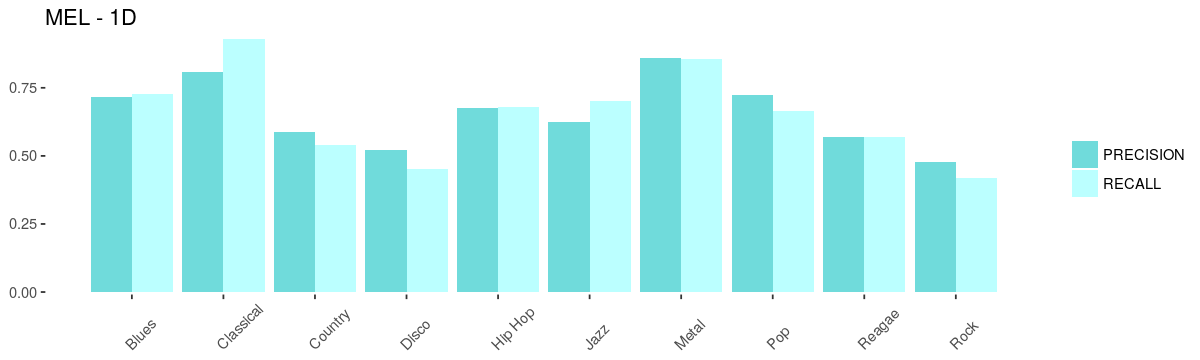

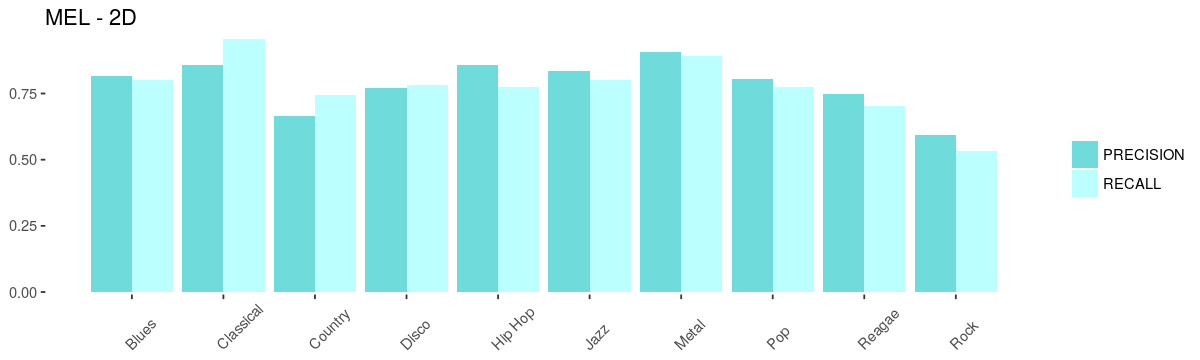

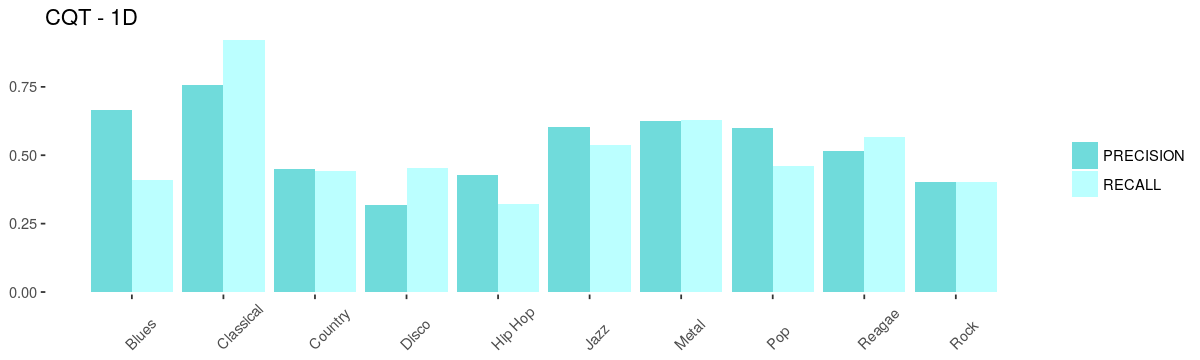

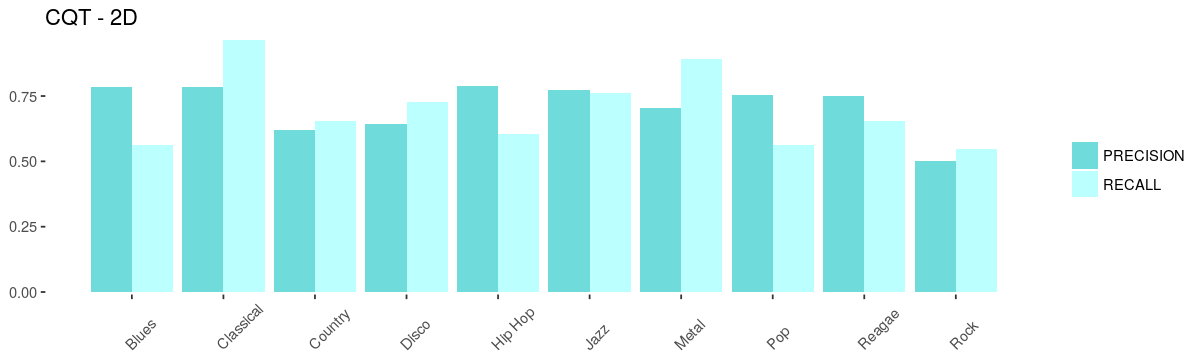

In [1]:
if (!require("ggplot2")) install.packages("ggplot2")
library("ggplot2")

if (!require("reshape")) install.packages("reshape")
library("reshape")

if (!require("cowplot")) install.packages("cowplot")
library("cowplot")

options(repr.plot.width=10, repr.plot.height=3)

CLASSES = c('Blues', 'Classical', 'Country', 'Disco', 'Hip Hop', 'Jazz', 'Metal', 'Pop', 'Reagae', 'Rock')

PATHS = list(
    c(src='../data/processed/results/MEL/1D', dim='1D', repr='MEL'),
    c(src='../data/processed/results/MEL/2D', dim='2D', repr='MEL'),
    c(src='../data/processed/results/QT/1D',  dim='1D', repr='CQT'),
    c(src='../data/processed/results/QT/2D',  dim='2D', repr='CQT')
)

for (path in PATHS) {
    PRECISION = rep(0, 10)
    RECALL = rep(0, 10)
    SAMPLES = 0

    for ( file in list.files(path['src'], full.names=TRUE, recursive=TRUE) ) {
        results = read.csv(file)
        PRECISION = PRECISION + results$pre
        RECALL = RECALL + results$rec
        SAMPLES = SAMPLES  + 1
    }

    PRECISION = PRECISION / SAMPLES
    RECALL = RECALL / SAMPLES
    
    DATA = melt(data.frame(PRECISION, RECALL, CLASSES), id.vars='CLASSES')
    
    plot =  ggplot(DATA) +
    geom_bar(aes(x=CLASSES, y=value, fill=variable), stat='identity', position='dodge') +
    scale_fill_manual(values = c("#70DBDB", "#BBFFFF")) +
    scale_x_discrete(expand = c(0.05, 0)) + scale_y_continuous(expand = c(0.01, 0)) +
    theme_classic() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 0, vjust = 0), axis.line = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        legend.title = element_blank()
    ) + 
    ggtitle(paste(path['repr'], path['dim'], sep= ' - '))
    
    print(plot)
} 

We appreciate that: 

1. **Country**, **Rock** and **Disco** are overall worst categories.
2. **Metal**, **Jazz** and **Pop** are, overall, the best categories.
3. MEL-based algoritms seem to perform better than CQT-based
4. 1D-based algoritms seem to perform better than 2D-based.

The weaker categories belong to similar musical genres. **Rock**, for instance can be seen as a "branch" of **country**, and somehow **pop** is grounded in rock as well. At the end of the day there're many David Bowie's songs where the distincition between rock and pop lies in a very fuzzy line, for instance. And listening the actual songs in GTZAN in this categories, seems to confirm this intuition.

On the other hand, the stronger categories tend to represent singular genres. If not generally speaking, at least in the context of this dataset.

Regarding the generic effects due to dimensionality or the sound representation in use, these are insights that we are about to confirm in an analitical fashion.

### ANOVA analysis

Let alone with precision and recall, each evaluation process recorded the overall accuracy of the model. Since **accuracy** is a global metric, we will use it to compare the four different types of algorithms we have created so far. 

Our experiment corresponds to a 2 way ANOVA design, bein "dimensionality of the algorithm" (1D or 2D) and "representation of sound" (MEL or CQT) the two factors we are going to contrast. Both of them has only 2 levels.

Hence, we want to test the following hypothesis:

1. H_0: There is no significant differences among the accuracies obtained using 1D or 2D driven algorithms.

2. H_0: There is no significant differences among the accuracies obtained using melspectograms or cqt-spectrograms.

3. H_0: There are no interacion effects among factors.



In [2]:
PATHS = list(
    c(src='../data/processed/results/MEL/1D', dim='1D', repr='MEL'),
    c(src='../data/processed/results/MEL/2D', dim='2D', repr='MEL'),
    c(src='../data/processed/results/QT/1D',  dim='1D', repr='CQT'),
    c(src='../data/processed/results/QT/2D',  dim='2D', repr='CQT')
)

DATA = data.frame(matrix(ncol=3, nrow=0))

colnames(DATA) <- c("dim", "repr", "acc")

for (path in PATHS) {
    for (file in list.files(path['src'], full.names=TRUE, recursive=TRUE)) {
        result = read.csv(file=file)
        DATA = rbind(DATA, list(
            "dim" = path['dim'],
            "repr"= path['repr'],
            "acc" = result$acc[[1]]), stringsAsFactors=FALSE)
    }
}

DATA$dim = factor(DATA$dim, levels=unique(DATA$dim))
DATA$repr = factor(DATA$repr, levels=unique(DATA$repr))

DATA[sample(nrow(DATA), 6), ]

,dim,repr,acc
81,1D,MEL,0.7133333
73,1D,MEL,0.6666667
285,1D,CQT,0.5000000
320,2D,CQT,0.7400000
323,2D,CQT,0.7333333
234,1D,CQT,0.5266667


### ANOVA

In [3]:
if (!require("car")) install.packages("car");

library("car")

model = lm(acc ~ dim + repr + dim:repr, data=DATA)

Anova(model, type='II')


Loading required package: car


,Sum Sq,Df,F value,Pr(>F)
dim,2.19953310,1,2884.42369,1.188813e-180
repr,1.19728396,1,1570.09423,9.700310e-138
dim:repr,0.07515464,1,98.55629,7.952936e-21
Residuals,0.29282131,384,NA,NA


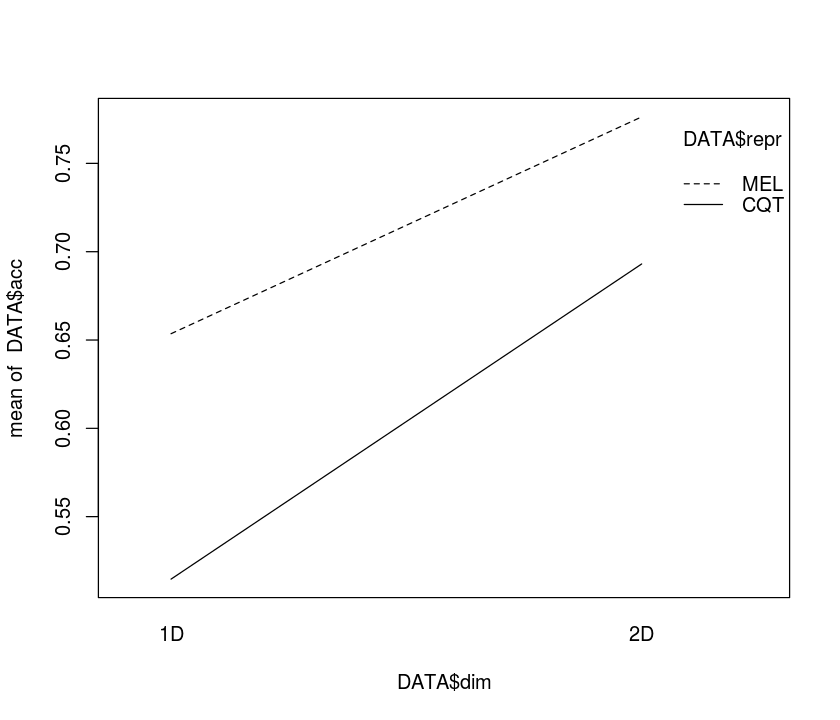

In [15]:
if (!require("repr")) install.packages("repr");
library(repr)

# Change plot size
options(repr.plot.width=7, repr.plot.height=6)
interaction.plot(DATA$dim, DATA$repr, DATA$acc)

In [4]:
MEL1D = DATA[DATA$dim == '1D' & DATA$repr == 'MEL', ]$acc
sprintf('MEL 1D avg accuracy::  mean(%.2f%%) sd(%.2f%%)', mean(MEL1D), sd(MEL1D))
MEL2D = DATA[DATA$dim == '2D' & DATA$repr == 'MEL', ]$acc
sprintf('MEL 2D avg accuracy::  mean(%.2f%%) sd(%.2f%%)', mean(MEL2D), sd(MEL2D))
CQT1D = DATA[DATA$dim == '1D' & DATA$repr == 'CQT', ]$acc
sprintf('CQT 1D avg accuracy::  mean(%.2f%%) sd(%.2f%%)', mean(CQT1D), sd(CQT1D))
CQT2D = DATA[DATA$dim == '2D' & DATA$repr == 'CQT', ]$acc
sprintf('CQT 2D avg accuracy::  mean(%.2f%%) sd(%.2f%%)', mean(CQT2D), sd(CQT2D))

[1] "MEL 1D avg accuracy::  mean(0.65%) sd(0.02%)"

[1] "MEL 2D avg accuracy::  mean(0.78%) sd(0.03%)"

[1] "CQT 1D avg accuracy::  mean(0.51%) sd(0.03%)"

[1] "CQT 2D avg accuracy::  mean(0.69%) sd(0.03%)"

After our analysis, we can conclude that: 

1. Melspectograms produce better models than CQT-spectrograms. (p-value < 0.001)
2. 2D-based algoritms produce better models than using 1D (p-value < 0.001)
3. There is interacion effects (p-value < 0.05 = alpha): 2D has a positive impact that is greater for models using CQT-spectrograms.

We conclude that:

> The 2D-based algorithms using Melspectograms strategy produces the best models among all the alternatives considered in our experiment. 